In [1]:
import sys
sys.path.append("..")

from ris_evaluation.evaluator import Evaluator

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from bertopic import BERTopic

/Users/yorest/miniconda3/envs/nlp/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yorest/miniconda3/envs/nlp/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/yorest/miniconda3/envs/nlp/lib/python3.9/site-packages/umap/distanc

In [2]:
documents_df = pd.read_csv('../datasets/data/BBC_News/documents.csv')
documents_df = documents_df

documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

In [3]:
bert_model = BERTopic(language="english", calculate_probabilities=True, nr_topics=6)
topics, probs = bert_model.fit_transform(documents)

In [4]:
bert_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,514,-1_government_firm_work_phone,"[government, firm, work, phone, technology, mo...",[network seek boost generation mobile network ...
1,0,688,0_government_election_party_labour,"[government, election, party, labour, company,...",[unveil election liberal present real alternat...
2,1,388,1_win_play_game_player,"[win, play, game, player, match, final, good, ...",[open victory win opening match tour champions...
3,2,328,2_film_good_award_music,"[film, good, award, music, win, star, show, ba...",[award comedy sideways dominate independent sp...
4,3,180,3_game_technology_mobile_device,"[game, technology, mobile, device, phone, gadg...",[console promise big problem game future conso...
5,4,127,4_virus_mail_site_security,"[virus, mail, site, security, software, attack...",[criminal step pace call attack trick confiden...


In [5]:
results_df = pd.DataFrame()
results_df['document'] = documents
results_df['y_true'] = labels
results_df['y_pred'] = topics
results_df['y_pred_highest_proba'] = np.max(probs, axis=1)

results_df

,document,y_true,y_pred,y_pred_highest_proba
0,hit shelf combine medium player phone gaming g...,tech,3,0.695718
1,bid hope join host apply host tournament aim r...,sport,-1,0.483453
2,lord wrong detainee straw straw attack decisio...,politics,0,1.000000
3,leak answer minister explain budget detail pri...,politics,0,0.788953
4,delight manager pay tribute goal striker beat ...,sport,1,0.643449
...,...,...,...,...
2220,rock clean steer clear bad language front awar...,entertainment,2,0.544601
2221,comedy meet sequel meet parent top week movie ...,entertainment,2,1.000000
2222,join rare group actress nominate oscar star fo...,entertainment,2,0.829723
2223,police chief back move chief back introduction...,politics,0,0.849544


In [6]:
def get_words_for_topics(topics):
    words_by_topics = {}
    for idx, topic in enumerate(topics):
        words = documents_df.iloc[idx]['document'].split()

        if topic not in words_by_topics:
            words_by_topics[topic] = {}

        for word in words:
            if word not in words_by_topics[topic]:
                words_by_topics[topic][word] = 0

            words_by_topics[topic][word] += 1

    return words_by_topics

In [7]:
relevant_results_df = results_df[results_df['y_pred'] != -1]

model_output = {
    "topics": [item for item in bert_model.get_topic_info()["Representation"]],
    "topic-document-matrix": probs.transpose(),
    "topic-word-matrix": bert_model.c_tf_idf_,
    "test-topic-document-matrix": probs.transpose()
}
evaluator = Evaluator(model_output)

words_by_extracted_topics = get_words_for_topics(relevant_results_df['y_pred'].tolist())
words_by_class = get_words_for_topics(relevant_results_df['y_true'].tolist())

In [8]:
coherence = evaluator.compute_coherence()
diversity = evaluator.compute_diversity()
supervised_correlation = evaluator.compute_supervised_correlation(words_by_extracted_topics, words_by_class)

metrics_df = pd.DataFrame()

for coherence_type, coherence_value in coherence.items():
    metrics_df[f'Coherence ({coherence_type})'] = [coherence_value]
metrics_df['Diversity'] = [diversity]
metrics_df['Supervised correlation'] = [supervised_correlation]
metrics_df

,Coherence (c_v),Coherence (c_uci),Coherence (c_npmi),Coherence (u_mass),Diversity,Supervised correlation
0,0.461502,-0.354452,0.015677,-2.441994,0.85,0.721166


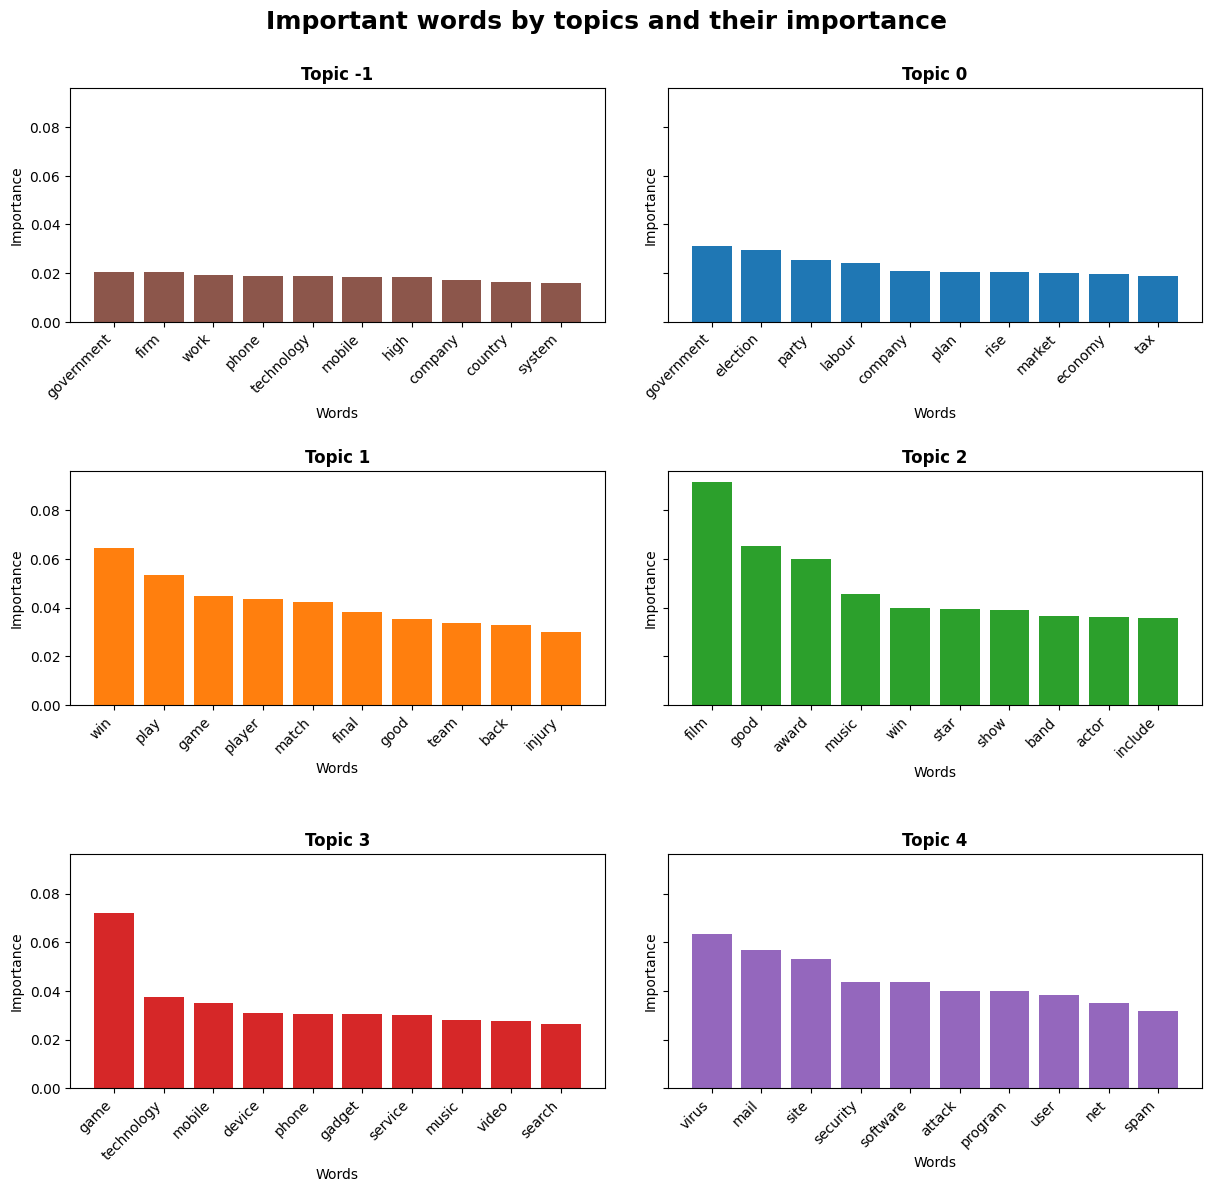

In [9]:
no_top_words = 10
x, y = 0, 0
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# Plotting the important words by topics and their importance
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey=True)
fig.suptitle('Important words by topics and their importance', fontsize=18, fontweight='bold')

for topic_idx, topic in enumerate(bert_model.get_topic_info()['Topic']):
    topic_idx = topic_idx - 1

    features = [feature[0] for feature in bert_model.get_topics()[topic_idx]]
    importance_for_features = [feature[1] for feature in bert_model.get_topics()[topic_idx]]

    ax = axes[x, y]
    ax.set_title(f'Topic {topic_idx}', fontsize=12, fontweight='bold')
    ax.bar(features, importance_for_features, color=colors[topic_idx])
    ax.set_xlabel('Words')
    ax.set_ylabel('Importance')
    ax.xaxis.set_ticks(features)
    ax.set_xticklabels(features, rotation=45, ha='right')

    if y == 1:
        x += 1
        y = 0
    else:
        y += 1

fig.tight_layout(pad=2.0, rect=[-0.02, -0.02, 1.02, 1])
fig.savefig('../figures/bertopic/important_words_by_topics.png')

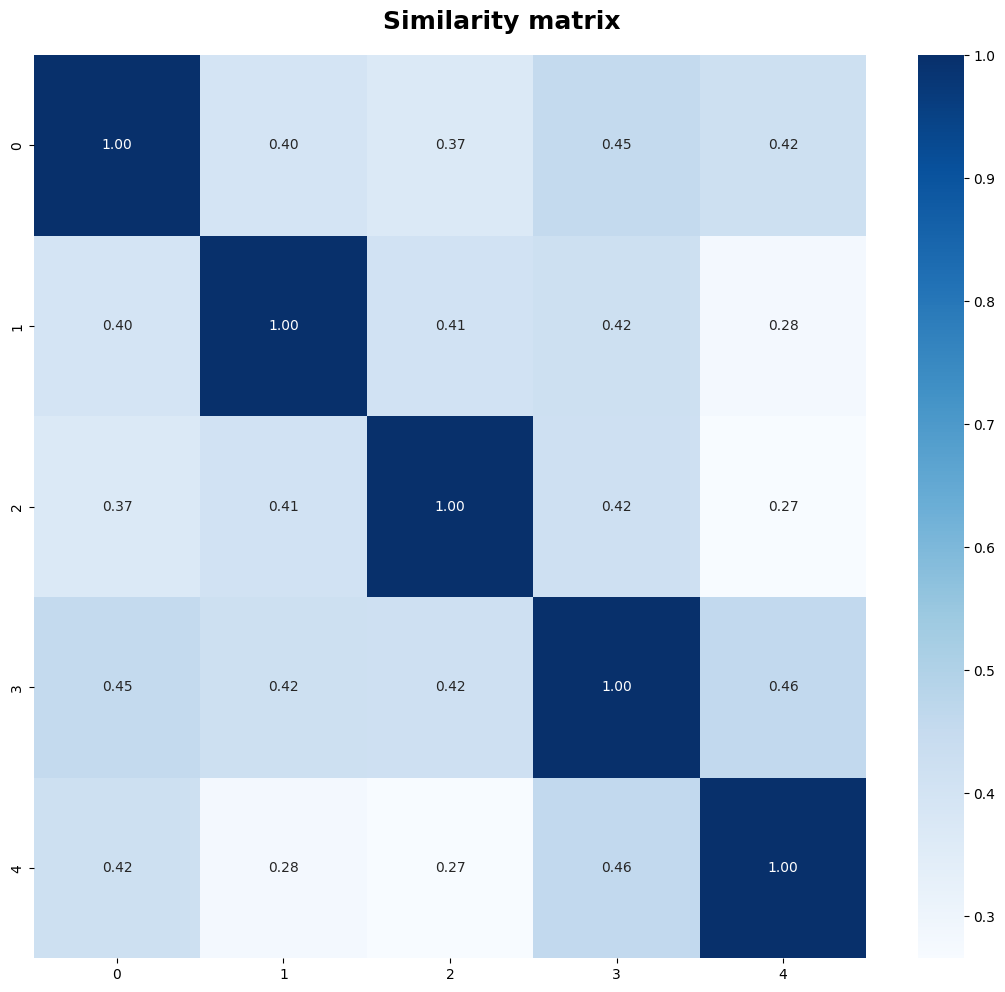

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

distance_matrix = cosine_similarity(bert_model.c_tf_idf_)
distance_matrix_labels = bert_model.get_topic_info()['Topic'].tolist()

# Removing the first row and column
distance_matrix = distance_matrix[1:, 1:]
distance_matrix_labels = distance_matrix_labels[1:]

# Plotting the distance matrix
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Similarity matrix', fontsize=18, fontweight='bold')

sns.heatmap(distance_matrix, ax=ax, cmap='Blues', xticklabels=distance_matrix_labels, yticklabels=distance_matrix_labels, annot=True, fmt='.2f')

fig.tight_layout(pad=2.0, rect=[-0.02, -0.02, 1.1, 1.02])
fig.savefig('../figures/bertopic/similarity_matrix.png')